In [1]:
import sys
import os

# Get the path to the parent directory (consumption)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to the Python path
sys.path.append(parent_dir)

# Now you can import the LSTMModel from the dnn.models module
from dnn.models import LSTMModel, LinearRegressionModel, MLPModel
from dnn.dataset import Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from setpoint_timeseries import generate_setpoint_timeseries

# Load data

### Setpoint timeseries

In [3]:
# full_heating_timeseries, full_cooling_timeseries = generate_setpoint_timeseries(
#     cooling_start_date = "2018-06-01",
#     cooling_end_date = "2018-10-31",
#     combine = False
# )

In [4]:
# # Save heaitng and cooling timeseries to pickle
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_heating_timeseries, f)
# with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'wb') as f:
#     pickle.dump(full_cooling_timeseries, f)

In [5]:
# Load full heating and cooling timeseries
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_heating_timeseries.pkl', 'rb') as f:
    full_heating_timeseries = pickle.load(f)
with open('/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/full_cooling_timeseries.pkl', 'rb') as f:
    full_cooling_timeseries = pickle.load(f)

### Weather data

In [6]:
weather_data = pd.read_csv("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/G2500170_2018.csv")

### ResStock

In [7]:
resstock = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/MA_baseline_metadata_and_annual_results.parquet")

### Building timeseries

In [8]:
building_data = pd.read_parquet("/Users/adrian/Documents/ICAI/TFG/Space-Conditioning-Electrification/data/consumption/1000-0.parquet")

### Setpoint timeseries plot

In [9]:
heating_timeseries = full_heating_timeseries[1000]
cooling_timeseries = full_cooling_timeseries[1000]

heating_timeseries = pd.concat([heating_timeseries.loc["2018-01-01":"2018-05-31"], heating_timeseries.loc["2018-11-01":"2018-12-31"]])
cooling_timeseries = cooling_timeseries.loc["2018-06-01":"2018-10-31"]

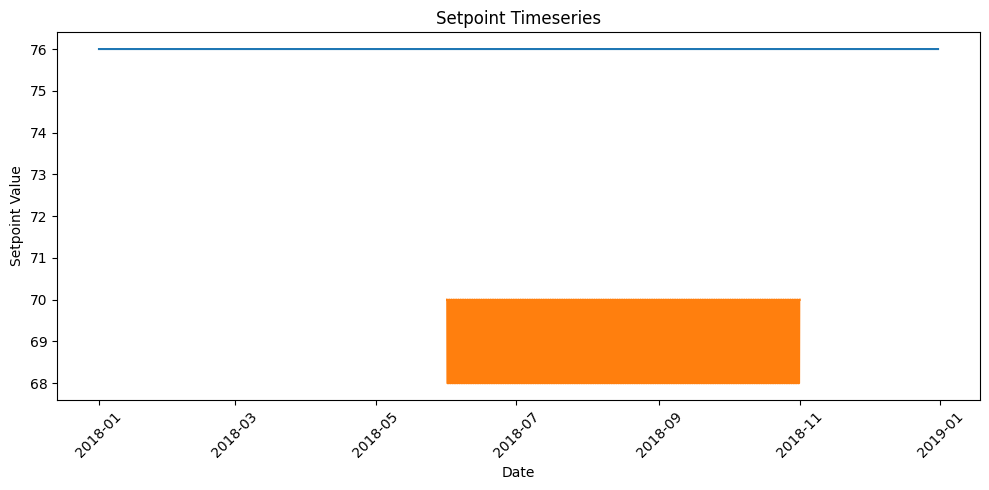

In [10]:
# Plot the timeseries
plt.figure(figsize=(10, 5))
plt.plot(heating_timeseries.index, heating_timeseries["setpoint"])
plt.plot(cooling_timeseries.index, cooling_timeseries["setpoint"])
plt.title("Setpoint Timeseries")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Transform data

In [11]:
def get_cols(building_data: pd.DataFrame, building_id: int) -> str:

    try:
        building = building_data.loc[building_id]
    except:
        raise ValueError("Building ID not found in the dataset")

    match building["in.heating_fuel"]:
        case  "Natural Gas":
            return "out.natural_gas.heating.energy_consumption"
        case "Electricity":
            return "out.electricity.heating.energy_consumption"
        case "Fuel Oil":
            return "out.fuel_oil.heating.energy_consumption"
        case "Propane":
            return "out.propane.heating.energy_consumption"
        case _:
            return "out.electricity.heating.energy_consumption"

In [12]:
# Change date time column name to timestamp
weather_data.rename(columns={'date_time': "timestamp"}, inplace=True)
weather_data.set_index('timestamp', inplace=True)
weather_data.index = pd.to_datetime(weather_data.index)

# Delete all columns except dry bulb temperature
weather_data = weather_data[["Dry Bulb Temperature [°C]"]]
weather_data.rename(columns={"Dry Bulb Temperature [°C]": "temperature"}, inplace=True)

# Create an entry for 2018-01-01 00:00:00
new_row = pd.DataFrame({'temperature': weather_data.iloc[0]['temperature']}, index=[pd.to_datetime('2018-01-01 00:00:00')])
weather_data = pd.concat([new_row, weather_data])

# Remove last 19 rows
weather_data = weather_data[:-24]

In [13]:
col_to_use = get_cols(resstock, 1000)
consumption_timeseries = building_data[["timestamp", col_to_use]]

# Resample to hourly data
consumption_timeseries["timestamp"] = pd.to_datetime(consumption_timeseries["timestamp"])
consumption_timeseries.set_index("timestamp", inplace=True)
consumption_timeseries = consumption_timeseries.resample("H").mean()
consumption_timeseries = consumption_timeseries[col_to_use]

consumption_timeseries = consumption_timeseries[:-24]

# Turn into dataframe
consumption_timeseries = pd.DataFrame(consumption_timeseries)
consumption_timeseries.rename(columns={col_to_use: "consumption"}, inplace=True)

In [14]:
exog_variables = pd.merge(
    consumption_timeseries,
    weather_data,
    left_index=True,
    right_index=True,
)

In [15]:
heating_exog = exog_variables.loc[heating_timeseries.index]
cooling_exog = exog_variables.loc[cooling_timeseries.index]

# Timeseries prediction

In [16]:
train_size = 0.8
heating_endog_train = heating_timeseries[:int(train_size * len(heating_timeseries))]
heating_endog_test = heating_timeseries[int(train_size * len(heating_timeseries)):]

heating_exog_train = heating_exog[:int(train_size * len(heating_exog))]
heating_exog_test = heating_exog[int(train_size * len(heating_exog)):]

cooling_endog_train = cooling_timeseries[:int(train_size * len(cooling_timeseries))]
cooling_endog_test = cooling_timeseries[int(train_size * len(cooling_timeseries)):]

cooling_exog_train = cooling_exog[:int(train_size * len(cooling_exog))]
cooling_exog_test = cooling_exog[int(train_size * len(cooling_exog)):]

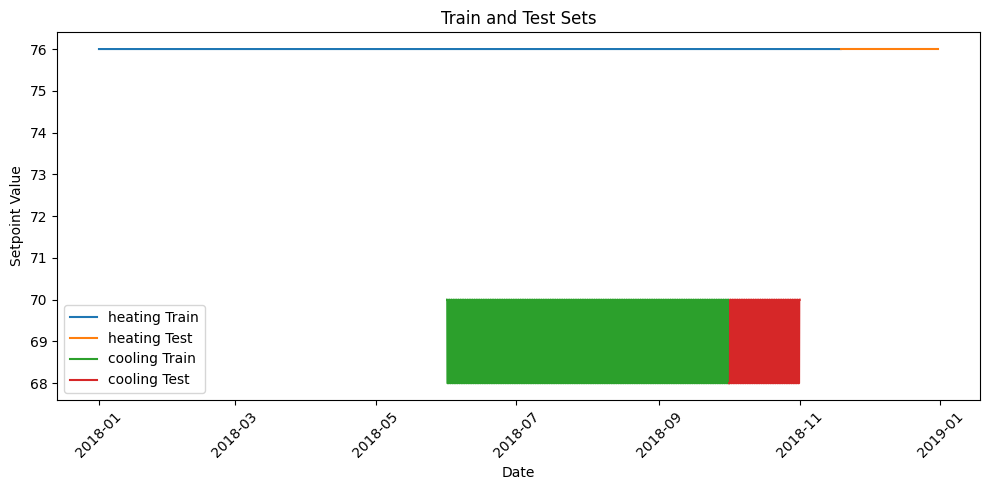

In [17]:
# Plot the training and test sets
plt.figure(figsize=(10, 5))
plt.plot(heating_endog_train.index, heating_endog_train["setpoint"], label="heating Train")
plt.plot(heating_endog_test.index, heating_endog_test["setpoint"], label="heating Test")
plt.plot(cooling_endog_train.index, cooling_endog_train["setpoint"], label="cooling Train")
plt.plot(cooling_endog_test.index, cooling_endog_test["setpoint"], label="cooling Test")
plt.title("Train and Test Sets")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ARIMA

In [ ]:
model = ARIMA(
    endog=endog_train,
    exog=exog_train,
    order=(1, 1, 1),
    seasonal_order=(1, 0, 1, 24),
    freq="h",
)
model_fit = model.fit()

In [ ]:
print(model_fit.summary())

In [ ]:
# Plot ACF and PACF

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(model_fit.resid, lags=50, ax=ax[0])
plot_pacf(model_fit.resid, lags=50, ax=ax[1])
plt.title("ACF and PACF")
plt.tight_layout()
plt.show()

In [ ]:
# Plot residuals
residuals = model_fit.resid
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title("Residuals")
plt.xlabel("Date")
plt.ylabel("Residual Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Predict
predictions = model_fit.get_forecast(steps=len(endog_test), exog=exog_test)
predicted_mean = predictions.predicted_mean
predicted_conf_int = predictions.conf_int()
lower_limits = predicted_conf_int.iloc[:, 0]
upper_limits = predicted_conf_int.iloc[:, 1]
predicted_mean = pd.Series(predicted_mean, index=endog_test.index)

In [ ]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(endog_train.index, endog_train["setpoint"], label="Train")
plt.plot(endog_test.index, endog_test["setpoint"], label="Test")
plt.plot(predicted_mean.index, predicted_mean, label="Predicted")
plt.title("ARIMA Predictions")
plt.xlabel("Date")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# LSTM

In [ ]:
train_data = pd.merge(
    endog_train,
    exog_train,
    left_index=True,
    right_index=True,
)

test_data = pd.merge(
    endog_test,
    exog_test,
    left_index=True,
    right_index=True,
)

In [ ]:
# pass train_data and test_data to numpy
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()

In [ ]:
# Hyperparameters
sequence_length = 24  # Number of past timesteps to look at
batch_size = 64

In [ ]:
# Create sequences and labels
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    
    for i in range(len(data) - sequence_length - 1):
        sequence = data[i:i+sequence_length]  # Get the sequence of past timesteps
        label = data[i+sequence_length, 0]    # Predict the setpoint (first feature)
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

In [ ]:
train_sequences, train_labels = create_sequences(train_data, sequence_length)
test_sequences, test_labels = create_sequences(test_data, sequence_length)

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [ ]:
train_dataset = TimeSeriesDataset(train_sequences, train_labels)
test_dataset = TimeSeriesDataset(test_sequences, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class LSTMSetpointPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.5):
        super(LSTMSetpointPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)  # Fully connected layer for the output

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # LSTM output
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step
        out = self.fc(lstm_out)       # Pass through fully connected layer
        return out


In [ ]:
# Model parameters
input_size = 3  # Setpoint, Weather, Heating_Energy_Consumption
hidden_size = 64
num_layers = 2
output_size = 1  # Predicting the setpoint
dropout = 0.7

In [ ]:
# Instantiate the model
model = LSTMSetpointPredictor(input_size, hidden_size, num_layers, output_size, dropout)

In [ ]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


In [ ]:
# Train the model
num_epochs = 100
train(model, train_loader, criterion, optimizer, num_epochs)

In [ ]:
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)


In [ ]:
# Get predictions and actuals
predictions, actuals = evaluate(model, test_loader)

In [ ]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(train_data[6000:, 0], label="Train")
plt.plot(np.arange(len(train_data) - 6000, len(train_data) - 6000 + len(test_data[:, 0])), test_data[:, 0], label="Test")
plt.plot(np.arange(len(train_data) - 6000, len(train_data) - 6000 + len(predictions)), predictions, label="Predicted")
plt.title("LSTM Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# LinearRegression

In [18]:
heating_train_timeseries = pd.merge(heating_endog_train, heating_exog_train, left_index=True, right_index=True)
heating_test_timeseries = pd.merge(heating_endog_test, heating_exog_test, left_index=True, right_index=True)

cooling_train_timeseries = pd.merge(cooling_endog_train, cooling_exog_train, left_index=True, right_index=True)
cooling_test_timeseries = pd.merge(cooling_endog_test, cooling_exog_test, left_index=True, right_index=True)

In [19]:
def create_lr_sequences(data, sequence_length):
    sequences = []
    labels = []

    for i in range(len(data) - sequence_length - 1):
        sequence = data.iloc[i:i+sequence_length]
        label = data.iloc[i+sequence_length].iloc[0]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), labels

In [20]:
sequence_length = 12
batch_size = 64

heating_train_sequences, heating_train_labels = create_lr_sequences(heating_train_timeseries, sequence_length)
heating_test_sequences, heating_test_labels = create_lr_sequences(heating_test_timeseries, sequence_length)

cooling_train_sequences, cooling_train_labels = create_lr_sequences(cooling_train_timeseries, sequence_length)
cooling_test_sequences, cooling_test_labels = create_lr_sequences(cooling_test_timeseries, sequence_length)

In [21]:
heating_train_sequences = heating_train_sequences.reshape(heating_train_sequences.shape[0], -1)
heating_test_sequences = heating_test_sequences.reshape(heating_test_sequences.shape[0], -1)

cooling_train_sequences = cooling_train_sequences.reshape(cooling_train_sequences.shape[0], -1)
cooling_test_sequences = cooling_test_sequences.reshape(cooling_test_sequences.shape[0], -1)

In [22]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [23]:
heating_train_dataset = TimeSeriesDataset(heating_train_sequences, heating_train_labels)
heating_test_dataset = TimeSeriesDataset(heating_test_sequences, heating_test_labels)
heating_train_loader = DataLoader(heating_train_dataset, batch_size=batch_size, shuffle=True)
heating_test_loader = DataLoader(heating_test_dataset, batch_size=batch_size, shuffle=False)

cooling_train_dataset = TimeSeriesDataset(cooling_train_sequences, cooling_train_labels)
cooling_test_dataset = TimeSeriesDataset(cooling_test_sequences, cooling_test_labels)
cooling_train_loader = DataLoader(cooling_train_dataset, batch_size=batch_size, shuffle=True)
cooling_test_loader = DataLoader(cooling_test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
# Instantiate the model
input_size = sequence_length * 3  # Setpoint, Weather, Heating_Energy_Consumption
output_size = 1
heating_model = LinearRegressionModel(input_size, output_size)

In [25]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(heating_model.parameters(), lr=0.001)

In [26]:
# Training function
def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for sequences, labels in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(sequences)
            loss = criterion(outputs, labels)  # Unsqueeze labels to match output dim
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')


In [27]:
# Train the model
num_epochs = 100
train(heating_model, heating_train_loader, criterion, optimizer, num_epochs)

Epoch 1/100, Loss: 4978.1399
Epoch 2/100, Loss: 797.4700
Epoch 3/100, Loss: 150.0143
Epoch 4/100, Loss: 65.6833
Epoch 5/100, Loss: 32.3580
Epoch 6/100, Loss: 14.9091
Epoch 7/100, Loss: 6.4175
Epoch 8/100, Loss: 2.9062
Epoch 9/100, Loss: 1.4655
Epoch 10/100, Loss: 0.9647
Epoch 11/100, Loss: 0.8027
Epoch 12/100, Loss: 0.7243
Epoch 13/100, Loss: 0.6958
Epoch 14/100, Loss: 0.6756
Epoch 15/100, Loss: 0.6558
Epoch 16/100, Loss: 0.6303
Epoch 17/100, Loss: 0.6149
Epoch 18/100, Loss: 0.6005
Epoch 19/100, Loss: 0.5816
Epoch 20/100, Loss: 0.5675
Epoch 21/100, Loss: 0.5637
Epoch 22/100, Loss: 0.5413
Epoch 23/100, Loss: 0.5231
Epoch 24/100, Loss: 0.5135
Epoch 25/100, Loss: 0.5045
Epoch 26/100, Loss: 0.4975
Epoch 27/100, Loss: 0.4879
Epoch 28/100, Loss: 0.4786
Epoch 29/100, Loss: 0.4637
Epoch 30/100, Loss: 0.4505
Epoch 31/100, Loss: 0.4457
Epoch 32/100, Loss: 0.4413
Epoch 33/100, Loss: 0.4290
Epoch 34/100, Loss: 0.4238
Epoch 35/100, Loss: 0.4087
Epoch 36/100, Loss: 0.4055
Epoch 37/100, Loss: 0.3955


In [28]:
# Predict
def evaluate(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            outputs = model(sequences)
            predictions.append(outputs.numpy())
            actuals.append(labels.numpy())
    return np.concatenate(predictions), np.concatenate(actuals)

In [29]:
# Get predictions and actuals
predictions, actuals = evaluate(heating_model, heating_test_loader)

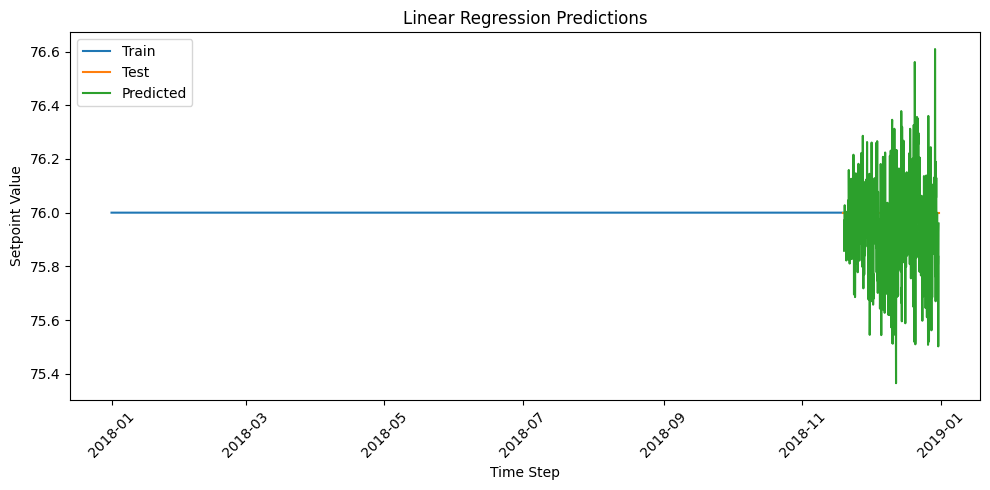

In [30]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train_timeseries.index, heating_train_timeseries["setpoint"], label="Train")
plt.plot(heating_test_timeseries.index, heating_test_timeseries["setpoint"], label="Test")
plt.plot(heating_test_timeseries.index[13:], predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cooling

In [31]:
cooling_model = LinearRegressionModel(input_size, output_size)

In [32]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(cooling_model.parameters(), lr=0.0001)

In [33]:
# train
num_epochs = 100
train(cooling_model, cooling_train_loader, criterion, optimizer, num_epochs)

Epoch 1/100, Loss: 6152.4260
Epoch 2/100, Loss: 5410.5036
Epoch 3/100, Loss: 4737.3042
Epoch 4/100, Loss: 4128.8671
Epoch 5/100, Loss: 3582.8615
Epoch 6/100, Loss: 3093.7230
Epoch 7/100, Loss: 2658.1245
Epoch 8/100, Loss: 2272.0472
Epoch 9/100, Loss: 1931.5445
Epoch 10/100, Loss: 1632.0087
Epoch 11/100, Loss: 1371.2933
Epoch 12/100, Loss: 1145.3643
Epoch 13/100, Loss: 950.2386
Epoch 14/100, Loss: 783.6907
Epoch 15/100, Loss: 641.9394
Epoch 16/100, Loss: 522.0922
Epoch 17/100, Loss: 421.8930
Epoch 18/100, Loss: 338.4998
Epoch 19/100, Loss: 269.7327
Epoch 20/100, Loss: 213.7420
Epoch 21/100, Loss: 168.1001
Epoch 22/100, Loss: 131.5630
Epoch 23/100, Loss: 102.4664
Epoch 24/100, Loss: 79.5951
Epoch 25/100, Loss: 61.6885
Epoch 26/100, Loss: 47.9066
Epoch 27/100, Loss: 37.2272
Epoch 28/100, Loss: 29.2735
Epoch 29/100, Loss: 23.2591
Epoch 30/100, Loss: 18.8221
Epoch 31/100, Loss: 15.5312
Epoch 32/100, Loss: 13.1610
Epoch 33/100, Loss: 11.4543
Epoch 34/100, Loss: 10.2697
Epoch 35/100, Loss: 9.

In [34]:
# Predict
cooling_predictions, actuals = evaluate(cooling_model, cooling_test_loader)

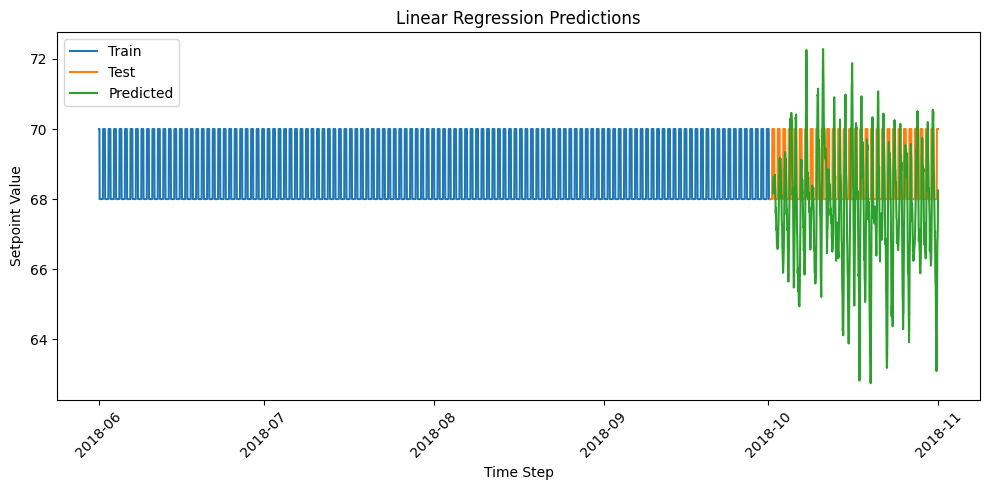

In [35]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_timeseries.index, cooling_train_timeseries["setpoint"], label="Train")
plt.plot(cooling_test_timeseries.index, cooling_test_timeseries["setpoint"], label="Test")
plt.plot(cooling_test_timeseries.index[13:], cooling_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# MLP

In [36]:
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [37]:
heating_model = MLPModel(input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size)

In [38]:
# Loss and optimizer
criterion = nn.MSELoss()
heating_optimizer = optim.Adam(heating_model.parameters(), lr=0.0001)

## Heating

In [39]:
num_epochs = 100
train(heating_model, heating_train_loader, criterion, heating_optimizer, num_epochs)

Epoch 1/100, Loss: 5220.3055
Epoch 2/100, Loss: 3747.4562
Epoch 3/100, Loss: 2272.0672
Epoch 4/100, Loss: 824.9251
Epoch 5/100, Loss: 154.0507
Epoch 6/100, Loss: 25.1749
Epoch 7/100, Loss: 14.1619
Epoch 8/100, Loss: 10.9025
Epoch 9/100, Loss: 8.3619
Epoch 10/100, Loss: 6.4438
Epoch 11/100, Loss: 4.5591
Epoch 12/100, Loss: 3.0519
Epoch 13/100, Loss: 2.0134
Epoch 14/100, Loss: 1.2471
Epoch 15/100, Loss: 0.6798
Epoch 16/100, Loss: 0.3672
Epoch 17/100, Loss: 0.2019
Epoch 18/100, Loss: 0.1378
Epoch 19/100, Loss: 0.1249
Epoch 20/100, Loss: 0.1188
Epoch 21/100, Loss: 0.1144
Epoch 22/100, Loss: 0.1087
Epoch 23/100, Loss: 0.1034
Epoch 24/100, Loss: 0.0994
Epoch 25/100, Loss: 0.0955
Epoch 26/100, Loss: 0.0910
Epoch 27/100, Loss: 0.0879
Epoch 28/100, Loss: 0.0832
Epoch 29/100, Loss: 0.0790
Epoch 30/100, Loss: 0.0749
Epoch 31/100, Loss: 0.0711
Epoch 32/100, Loss: 0.0653
Epoch 33/100, Loss: 0.0579
Epoch 34/100, Loss: 0.0468
Epoch 35/100, Loss: 0.0406
Epoch 36/100, Loss: 0.0372
Epoch 37/100, Loss: 0

In [40]:
# Predict
heating_predictions, heating_actuals = evaluate(heating_model, heating_test_loader)

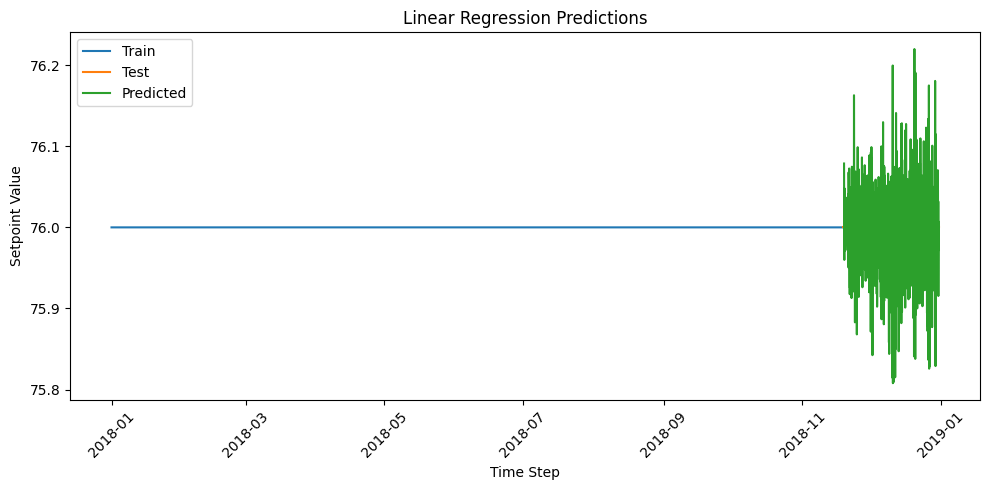

In [41]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(heating_train_timeseries.index, heating_train_timeseries["setpoint"], label="Train")
plt.plot(heating_test_timeseries.index, heating_test_timeseries["setpoint"], label="Test")
plt.plot(heating_test_timeseries.index[13:], heating_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Cooling

In [42]:
hidden_size_1 = 64
hidden_size_2 = 32
output_size = 1

In [43]:
cooling_model = MLPModel(input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, output_size=output_size)

In [44]:
# Loss and optimizer
criterion = nn.MSELoss()
cooling_optimizer = optim.Adam(cooling_model.parameters(), lr=0.0001)

In [45]:
num_epochs = 100
train(cooling_model, cooling_train_loader, criterion, cooling_optimizer, num_epochs)

Epoch 1/100, Loss: 4454.5987
Epoch 2/100, Loss: 3423.7682
Epoch 3/100, Loss: 2489.9887
Epoch 4/100, Loss: 1523.2976
Epoch 5/100, Loss: 610.2903
Epoch 6/100, Loss: 160.0401
Epoch 7/100, Loss: 30.5158
Epoch 8/100, Loss: 10.9016
Epoch 9/100, Loss: 8.8305
Epoch 10/100, Loss: 8.3245
Epoch 11/100, Loss: 7.8981
Epoch 12/100, Loss: 7.5759
Epoch 13/100, Loss: 7.1538
Epoch 14/100, Loss: 6.8063
Epoch 15/100, Loss: 6.4107
Epoch 16/100, Loss: 6.0691
Epoch 17/100, Loss: 5.7153
Epoch 18/100, Loss: 5.3981
Epoch 19/100, Loss: 5.0868
Epoch 20/100, Loss: 4.7943
Epoch 21/100, Loss: 4.5035
Epoch 22/100, Loss: 4.2545
Epoch 23/100, Loss: 3.9855
Epoch 24/100, Loss: 3.7206
Epoch 25/100, Loss: 3.5097
Epoch 26/100, Loss: 3.2961
Epoch 27/100, Loss: 3.0935
Epoch 28/100, Loss: 2.9115
Epoch 29/100, Loss: 2.7688
Epoch 30/100, Loss: 2.6123
Epoch 31/100, Loss: 2.4665
Epoch 32/100, Loss: 2.3449
Epoch 33/100, Loss: 2.2414
Epoch 34/100, Loss: 2.1349
Epoch 35/100, Loss: 2.0518
Epoch 36/100, Loss: 1.9862
Epoch 37/100, Loss:

In [48]:
# Predict
cooling_predictions, cooling_actuals = evaluate(cooling_model, cooling_test_loader)

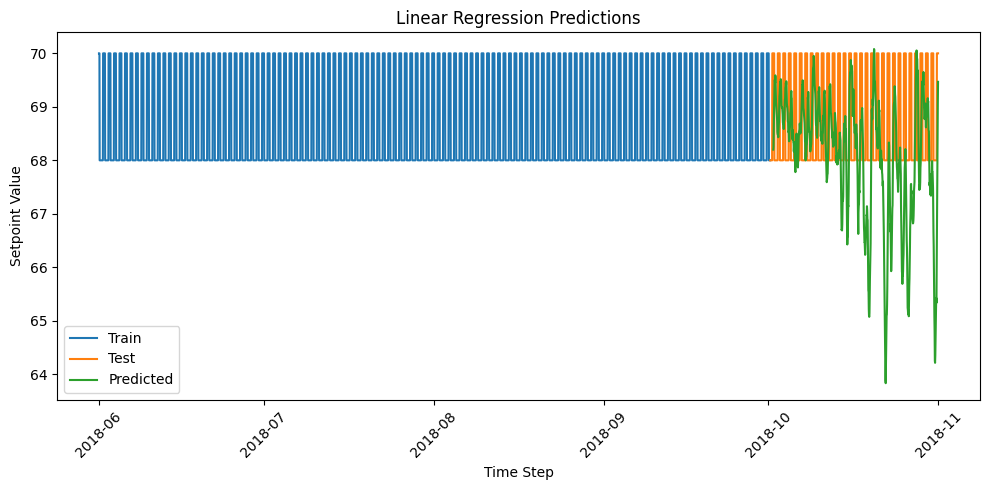

In [49]:
# Plot train, test and predictions
plt.figure(figsize=(10, 5))
plt.plot(cooling_train_timeseries.index, cooling_train_timeseries["setpoint"], label="Train")
plt.plot(cooling_test_timeseries.index, cooling_test_timeseries["setpoint"], label="Test")
plt.plot(cooling_test_timeseries.index[13:], cooling_predictions, label="Predicted")
plt.title("Linear Regression Predictions")
plt.xlabel("Time Step")
plt.ylabel("Setpoint Value")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Akaike

In [50]:
def compute_aic(y_true, y_pred, num_params):
    n = y_true.numel()
    residuals = y_true - y_pred
    rss = torch.sum(residuals ** 2).item()
    sigma2 = rss / n
    log_likelihood = -n/2 * (np.log(2 * np.pi * sigma2) + 1)
    aic = 2 * num_params - 2 * log_likelihood
    return aic

In [51]:
heating_num_params = sum(p.numel() for p in heating_model.parameters() if p.requires_grad)

In [52]:
heating_aic = compute_aic(
    torch.tensor(heating_actuals), 
    torch.tensor(heating_predictions), 
    heating_num_params
)

In [53]:
heating_aic

np.float64(12889.28419410738)

In [54]:
cooling_num_params = sum(p.numel() for p in cooling_model.parameters() if p.requires_grad)
cooling_aic = compute_aic(
    torch.tensor(cooling_actuals), 
    torch.tensor(cooling_predictions), 
    cooling_num_params
)
cooling_aic

np.float64(16494.39692623401)